In [3]:
# !pip install arabic_reshaper
# !pip install bidi.algorithm
# !pip install keras_cv

### Import necessary libraries

In [1]:

import os
import joblib
import random
import numpy as np
import bidi.algorithm
import arabic_reshaper
import tensorflow as tf
from pathlib import Path
from random import choices
from tqdm.auto import tqdm
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Reshape


/var/folders/k0/xyr88w796ng5f5xlvzhrhy_40000gq/T/ipykernel_1147/3075399403.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


###  Generate the image dataset for training the model

In [2]:

def generate_arabic_text_image(word, font_size, font_path, image_width=224, image_height=224, output_filename='output_image.png'):
    image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
    image.fill(255)

    pil_image = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_image)

    arabic_text = word
    font = ImageFont.truetype(font_path, int(font_size))

    text_bbox = draw.textbbox((0, 0), arabic_text, font=font)
    text_x = (image_width - text_bbox[2]) // 2
    text_y = (image_height - text_bbox[3]) // 2

    arabic_text_reversed = arabic_reshaper.reshape(bidi.algorithm.get_display(arabic_text))
    draw.text((text_x, text_y), arabic_text_reversed, font=font, fill=(0, 0, 0))

    image = np.array(pil_image)

    output_path = os.path.join(os.getcwd(), output_filename)
    pil_image.save(output_path)

    return image

def generate_sentences(words, num_sentences):
    sentences = []
    for _ in range(num_sentences):
        sentence = " ".join(choices(words, k=4))
        sentences.append(sentence)
    return sentences

def generate_images_for_sentences(sentences, font_sizes, font_paths):
    for sentence in sentences:
        for font_size, font_path in zip(font_sizes, font_paths):
            font_path = Path(font_path)
            reshaped_sentence = arabic_reshaper.reshape(sentence)
            font_name = font_path.stem
            output_filename = font_path.parent / font_name / f"{reshaped_sentence}.png"
            output_filename.parent.mkdir(exist_ok=True, parents=True)
            generate_arabic_text_image(str(reshaped_sentence), font_size, str(font_path), output_filename=str(output_filename))

if __name__ == "__main__":
    text = """
وَتأتي علَى قَدْرِ الكِرامِ المَكارمُ
وَتَعْظُمُ في عَينِ الصّغيرِ صغارُها 
ساداتُ كلّ أناسٍ من نفوسهمُ وسادةُ المسلمينَ الأَعبد القزمُ 
أغايةُ الدّينِ أنْ تَحفوا شواربكم يا أُمةٌ ضحكت من جهلها الأممُ 
وَاحَرّ قَلْباهُ ممّنْ قَلْبُهُ شَبِمُ وَمَنْ بجِسْمي وَحالي عِندَهُ سَقَمُ 
ما لي أُكَتِّمُ حُبًّا قَدْ بَرَى جَسَدي وَتَدّعي حُبّ سَيفِ الدّوْلةِ الأُمَمُ 
لا تشتَرِالعَبد إلا والعَصَا معه إِن العَبِيدَ لأنجاسٌ مَناكيد 
ما كُنتُ أَحسَبُني أَحيا إلى زَمَن يُسيء بي فيهِ عَبد وَهْوَ مَحمودُ
إذا شئت أن تلقى المحاسن كلها ففي وجه من تهوى جميع المحاسن
عَذْلُ العَواذِلِ حَوْلَ قَلبي التّائِهِ وَهَوَى الأحِبّةِ مِنْهُ في سَوْدائِهِ 
يَشْكُو المَلامُ إلى اللّوائِمِ حَرَّهُ وَيَصُدُّ حينَ يَلُمْنَ عَنْ بُرَحائِهِ 
وبمُهْجَتي يا عَاذِلي المَلِكُ الذي أسخَطتُ أعذَلَ مِنكَ في إرْضائِهِ 
أرَى مُرْهَفاً مُدهِشَ الصّيقَلِينَ وبابَةَ كُلّ غُلامٍ عَتَا أتأذَنُ لي ولَكَ السّابِقاتُ أُجَرّبُهُ لَكَ في ذا الفَتى
لَقَدْ نَسَبُوا الخِيامَ إلى علاءٍ أبَيْتُ قَبُولَهُ كُلَّ الإبَاءِ 
وَمَا سَلّمْتُ فَوْقَكَ للثّرَيّا وَلا سَلّمْتُ فَوْقَكَ للسّمَاءِ
وَقد أوحَشْتَ أرْضَ الشّامِ حَتّى سَلَبْتَ رُبُوعَهَا ثَوْبَ البَهَاءِ 
تَمَلّكَهَا الآتي تَمَلُّكَ سَالِبٍ وَفارَقَهَا المَاضِي فِراقَ سَليبِ 
وَلا فَضْلَ فيها للشّجاعَةِ وَالنّدَى وَصَبْرِ الفَتى لَوْلا لِقاءُ شَعُوبِ
وَأوْفَى حَيَاةِ الغَابِرِينَ لِصاحِبٍ حَياةُ امرِىءٍ خَانَتْهُ بَعدَ مَشيبِ 
لأبْقَى يَمَاكٌ في حَشَايَ صَبَابَةً إلى كُلّ تُرْكيّ النّجارِ جَليبِ 
وما استَغرقتُ وَصْفَكَ في مَديحي فأنْقُصَ مِنْهُ شَيئاً بالهِجَاءِ 
وهَبْني قُلتُ: هذا الصّبْحُ لَيْلٌ أيَعْمَى العالمُونَ عَنِ الضّياءِ
هَلِ الحَدَثُ الحَمراءُ تَعرِفُ لوْنَها وَتَعْلَمُ أيُّ السّاقِيَيْنِ الغَمَائِمُ سَقَتْها الغَمَامُ الغُرُّ قَبْلَ نُزُولِهِ
فَلَمّا دَنَا مِنها سَقَتها الجَماجِمُ بَنَاهَا فأعْلى وَالقَنَا يَقْرَعُ القَنَا وَمَوْجُ المَنَايَا حَوْلَها مُتَلاطِمُ ومن
الجدير بالذكر أنّ المُتنبِّي يستمرُّ في مدحه لسيف الدولة وبيان مدى شجاعته وصلابته في
القتال، فيقول في أبيات مختارة من قصيدته نفسها: وَقَفْتَ وَما في المَوْتِ شكٌّ لوَاقِفٍ كأنّكَ 
في جَفنِ الرّدَى وهْوَ نائِمُ تَمُرّ بكَ الأبطالُ كَلْمَى هَزيمَةً وَوَجْهُكَ وَضّاحٌ وَثَغْرُكَ باسِمُ ضَمَمْتَ جَناحَيهِمْ 
على القلبِ ضَمّةً تَمُوتُ الخَوَافي تحتَها وَالقَوَادِمُ وَمَنْ طَلَبَ الفَتْحَ الجَليلَ فإنّمَا مَفاتِيحُهُ البِيضُ الخِفافُ الصّوَارِمُ
ولي وطنٌ آليتُ ألا أبيعَهُ وألا أرى غيري له الدهرَ مالكاً عهدتُ به شرخَ الشبابِ ونعمةً كنعمةِ قومٍ أصبحُوا في
ظلالِكا وحبَّبَ أوطانَ الرجالِ إِليهمُ مآربُ قضاها الشبابُ هنالكا إِذا ذَكَروا أوطانهم ذكرَّتهمُ عهودَ الصِّبا فيها فَحنُّوا
لذاكا فقد ألفتهٌ النفسُ حتى كأنهُ لها جسدٌ إِن بان غودرَ هالكا موطنُ الإِنسانِ أمٌ فإِذا عقَّهُ الإِنسانُ يوماً عقَّ أمَّه
عشقت لأجلك كل جميل وهمت لأجلك في كل وادي ومن هام فيك 
أحب الجمال وإن لامه الغشم قال: بلادي لأجل بلادي عصرت النجوم وأترعت 
كاسي وصغت الشوادي وأرسلت شعري يسوق الخطى بساح الفدا يوم نادى المنادي وأوقفت ركب الزمان طويلاً أُسائله عن 
ثمود وعاد وعن قصة المجد من عهد نوح وهل إرم هي ذات العماد؟ فاقسم هذا الزمان يميناً وقال: بلادي دون عناد
ألقيت بين يديك السيف والقلم لولا الإله لكان البيت والحرم أنتِ الهنا
والعنا أنتِ المنى وأنا على ثراك وليد قد نما وسما أماه أماه هذا اللحن يسحرني وينثر العطر
في جنبي مبتسم ما زال طيفك في دنياي يتبعني أنا سريت وقلبي يجحد النعم حتى وقعت أسير البغي
فانصرفت عني القلوب سوى يسيل دماً أصحو عليه وأغفو وهو يلثمني قلب ضعيف ويغزو الصحو والحلم
ويدخل السجن منسلاً فيدهشني إذ يستبيح من السجان شر حما فإن رآني على خير بكى فرحاً وإن
رآني على سوء بكى ألماً فلتغفري لي ذنبي يا معذِّبتي أو حاكميني وكوني الخصم والحكم
"""

    words = text.replace("\n", " ").split(" ")
    num_sentences = 4000

    font_size = [30, 30, 30, 30, 30]
    font_paths = [
        './arabic_font/Kufic_Font.ttf',
        './arabic_font/Naskh_Font.ttf',
        './arabic_font/Thuluth_Font.ttf',
        './arabic_font/Ruqah_Font.ttf',
        './arabic_font/Diwani_Font.ttf',
    ]

    sentences = generate_sentences(words, num_sentences)
    generate_images_for_sentences(sentences, font_size, font_paths)


### Model Architecture and training

In [5]:

# Define constants
MAIN_DIRECTORY = './image_set'
BATCH_SIZE = 50
SEED = 24
NUM_CLASSES = 5
IMAGE_SIZE = (224, 224)
EPOCHS = 30

# Get class folders
CLASS_FOLDERS = sorted([f for f in os.listdir(MAIN_DIRECTORY) if os.path.isdir(os.path.join(MAIN_DIRECTORY, f))])

# Create base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Build the model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(CLASS_FOLDERS))(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [6]:

# Create data generators
datagen_original = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
)

datagen_augmented = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.1, 
    zoom_range=0.2, 
    rotation_range=20, 
    validation_split=0.2,
)

# Define generators
train_generator_augmented = datagen_augmented.flow_from_directory(
    MAIN_DIRECTORY,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    seed=SEED,
)

validation_generator_original = datagen_original.flow_from_directory(
    MAIN_DIRECTORY,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    seed=SEED,
)

# Define callbacks
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
checkpoint_path = './Classify_model.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
)
callbacks = [
    early_stopping, 
    model_checkpoint, 
    tensorboard_callback,
]

# Train the model
history = model.fit(
    train_generator_augmented,
    epochs=EPOCHS,
    validation_data=validation_generator_original,
    callbacks=callbacks,
)

Found 16000 images belonging to 5 classes.
Found 4000 images belonging to 5 classes.
Epoch 1/30
320/320 [==============================] - ETA: 0s - loss: 1.0049 - accuracy: 0.6141
Epoch 1: val_loss improved from inf to 0.55052, saving model to ./Classify_model.h5


/Users/saraalbogami/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 538s 2s/step - loss: 1.0049 - accuracy: 0.6141 - val_loss: 0.5505 - val_accuracy: 0.7685
Epoch 2/30
320/320 [==============================] - ETA: 0s - loss: 0.6024 - accuracy: 0.7721
Epoch 2: val_loss improved from 0.55052 to 0.44236, saving model to ./Classify_model.h5
320/320 [==============================] - 526s 2s/step - loss: 0.6024 - accuracy: 0.7721 - val_loss: 0.4424 - val_accuracy: 0.8280
Epoch 3/30
320/320 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.8090
Epoch 3: val_loss improved from 0.44236 to 0.32109, saving model to ./Classify_model.h5
320/320 [==============================] - 532s 2s/step - loss: 0.4925 - accuracy: 0.8090 - val_loss: 0.3211 - val_accuracy: 0.8765
Epoch 4/30
320/320 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.8244
Epoch 4: val_loss improved from 0.32109 to 0.29217, saving model to ./Classify_model.h5
320/320 [==============================] - 511s 2s/s

### Plot the training and validation metric values over epochs

In [7]:
def plot_metric(history, metric, ylabel, title):
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']

    plt.plot(train_metric, label=f'Train {metric}')
    plt.plot(val_metric, label=f'Validation {metric}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

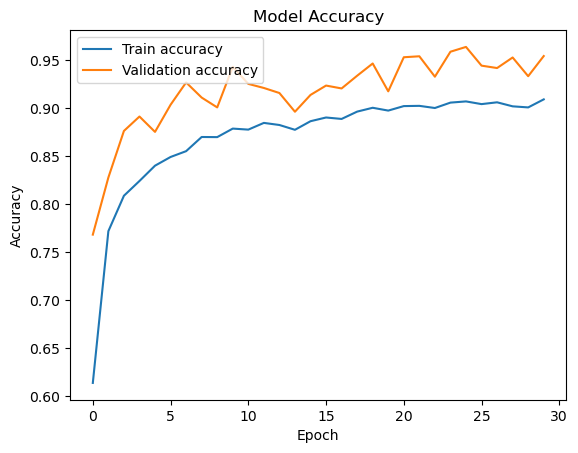

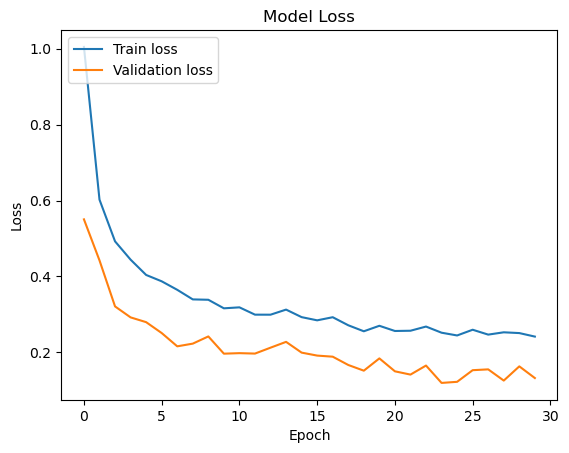

In [8]:
plot_metric(history, 'accuracy', 'Accuracy', 'Model Accuracy')
plot_metric(history, 'loss', 'Loss', 'Model Loss')

### Display a batch of images generated by an image generator

In [9]:
BATCH_SIZE = 4

def display_images_from_generator(image_generator, batch_size, figsize=(15, 15)):
    images, _ = image_generator.next()

    fig, axes = plt.subplots(1, batch_size, figsize=figsize)
    for i in range(batch_size):
        axes[i].imshow(images[i])
        axes[i].axis('off')

    plt.show()

def create_and_display_images(datagen, batch_size, subset='training', figsize=(15, 15)):
    image_generator = datagen.flow_from_directory(
        MAIN_DIRECTORY,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse',
        subset=subset,
    )

    display_images_from_generator(image_generator, batch_size, figsize)

Found 16000 images belonging to 5 classes.


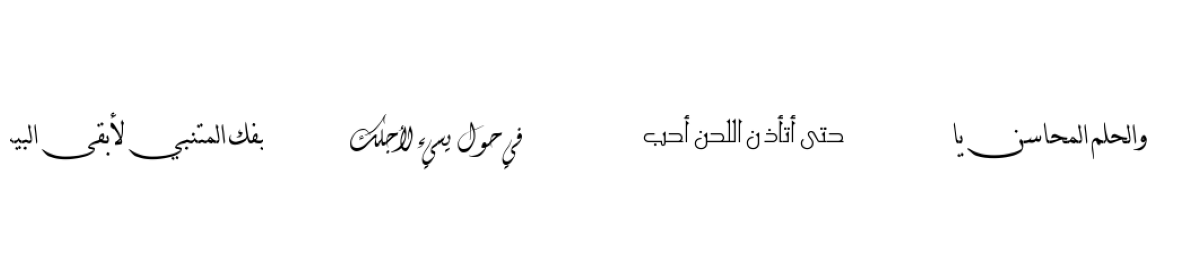

Found 16000 images belonging to 5 classes.


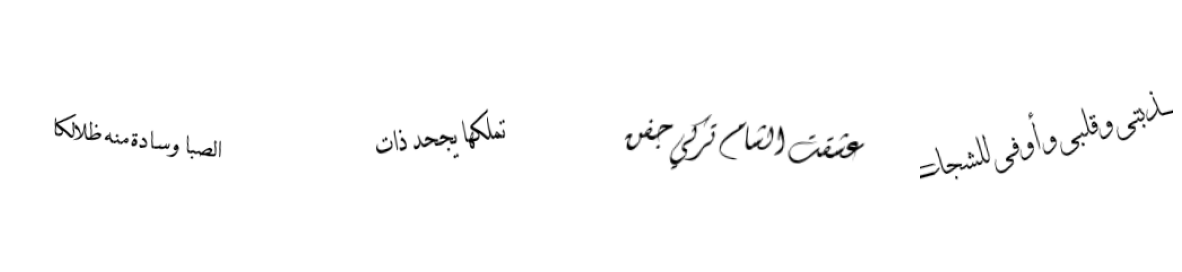

In [35]:
create_and_display_images(datagen_original, BATCH_SIZE);

create_and_display_images(datagen_augmented, BATCH_SIZE);

### Save and load a pre-trained model

In [14]:
model.save('./Classify_model.h5')
loaded_model = tf.keras.models.load_model('./Classify_model.h5')

/Users/saraalbogami/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
joblib.dump(model, 'Classifier_model.joblib')

['Classifier_model.joblib']

### Evaluate the model 

In [36]:
# Evaluate the model on the validation data
def evaluate_model(model, generator):
    evaluation = model.evaluate(generator)
    loss, accuracy = evaluation
    return loss, accuracy

def print_evaluation_results(loss, accuracy):
    print("Loss: {:.4f}".format(loss))
    print("Accuracy: {:.2f}%".format(accuracy * 100))

validation_loss, validation_accuracy = evaluate_model(loaded_model, validation_generator_original)
print_evaluation_results(validation_loss, validation_accuracy)

80/80 [==============================] - 100s 1s/step - loss: 0.1195 - accuracy: 0.9590
Loss: 0.1195
Accuracy: 95.90%


In [17]:
# Evaluate the model on the testing data
def predict_test(img_path):
    original_img = image.load_img(img_path)
    original_size = original_img.size

    img_array = image.img_to_array(original_img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = loaded_model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=-1)
    predicted_class_label = CLASS_FOLDERS[int(predicted_class_index)]
    
    return predicted_class_label

test_set_path = './test_set'

test_directories = [str(directory) for directory in Path(test_set_path).glob('*')]

count = 0
acc_test = 0

for directory in tqdm(test_directories):
    for path in Path(directory).glob('*.png'):
        label = path.parent.name
        acc_test += label == predict_test(str(path))
        count += 1

acc_test /= count

print(f"Test Set Accuracy: {acc_test:%}")


  0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 0s 82ms/step


/var/folders/k0/xyr88w796ng5f5xlvzhrhy_40000gq/T/ipykernel_1147/3001781925.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class_label = CLASS_FOLDERS[int(predicted_class_index)]


1/1 [==============================] - 0s 64ms/step
Test Set Accuracy: 86.200000%


In [18]:
# Evaluate accuracy with square and cropped preprocessing
def load_and_preprocess_image(img_path, crop=True):
    if crop:
        original_img = image.load_img(img_path)
        original_size = original_img.size
        crop_size = (220, 150)
        start_x = (original_size[0] - crop_size[0]) // 2
        start_y = (original_size[1] - crop_size[1]) // 2
        cropped_img = original_img.crop((start_x, start_y, start_x + crop_size[0], start_y + crop_size[1]))
    else:
        cropped_img = image.load_img(img_path, target_size=IMAGE_SIZE)

    img_array = image.img_to_array(cropped_img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    return img_array

def predict_image(img_array, model):
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=-1)
    predicted_class_label = CLASS_FOLDERS[int(predicted_class_index)]

    return predicted_class_label

def evaluate_accuracy(selected_paths, model, crop=True):
    count = 0
    correct_predictions = 0
    for path in tqdm(selected_paths):
        label = path.parent.name
        img_array = load_and_preprocess_image(str(path), crop=crop)
        predicted_label = predict_image(img_array, model)
        correct_predictions += label == predicted_label
        count += 1

    accuracy = correct_predictions / count

    return accuracy

selected_paths = np.random.choice(list(Path('image_set').glob('*/*.png')), 2000)
acc_cropped = evaluate_accuracy(selected_paths, loaded_model, crop=True)
acc_square = evaluate_accuracy(selected_paths, loaded_model, crop=False)

print(f"Cropped Accuracy: {acc_cropped:%}")
print(f"Square  Accuracy: {acc_square:%}")

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


/var/folders/k0/xyr88w796ng5f5xlvzhrhy_40000gq/T/ipykernel_1147/3685900975.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class_label = CLASS_FOLDERS[int(predicted_class_index)]


1/1 [==============================] - 0s 52ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 68ms/step
Cropped Accuracy: 33.600000%
Square  Accuracy: 95.500000%


### Make predictions using the model

In [19]:
def load_and_predict_image(model, img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    plt.imshow(img)
    plt.axis('off')  
    plt.show()

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=-1)
    predicted_class_label = CLASS_FOLDERS[int(predicted_class_index)]

    print("Predicted Class: {}".format(predicted_class_label))


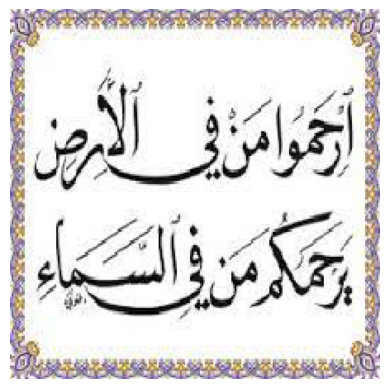

1/1 [==============================] - 0s 70ms/step
Predicted Class: خط النسخ


/var/folders/k0/xyr88w796ng5f5xlvzhrhy_40000gq/T/ipykernel_1147/2755560036.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class_label = CLASS_FOLDERS[int(predicted_class_index)]


In [46]:
img_path = './pred_image/naskh_test.jpeg'
load_and_predict_image(loaded_model, img_path)

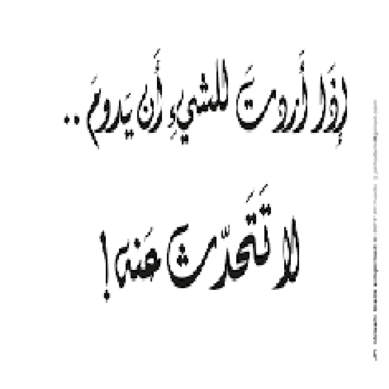

1/1 [==============================] - 0s 70ms/step
Predicted Class: الخط الديواني


/var/folders/k0/xyr88w796ng5f5xlvzhrhy_40000gq/T/ipykernel_1147/2755560036.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class_label = CLASS_FOLDERS[int(predicted_class_index)]


In [38]:
img_path = './pred_image/diwany_tset.png'
load_and_predict_image(loaded_model, img_path)

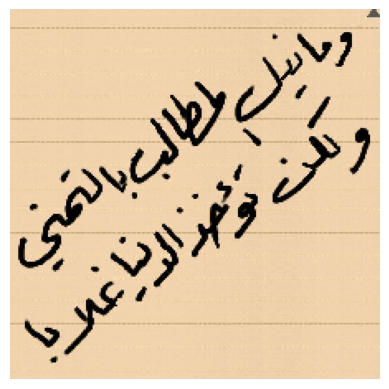

1/1 [==============================] - 0s 87ms/step
Predicted Class: خط الرقعة


/var/folders/k0/xyr88w796ng5f5xlvzhrhy_40000gq/T/ipykernel_1147/2755560036.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class_label = CLASS_FOLDERS[int(predicted_class_index)]


In [52]:
img_path = './pred_image/rug_test.jpg_large'
load_and_predict_image(loaded_model, img_path)

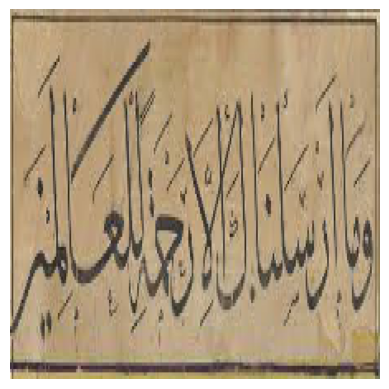

1/1 [==============================] - 0s 81ms/step
Predicted Class: الخط الكوفي


/var/folders/k0/xyr88w796ng5f5xlvzhrhy_40000gq/T/ipykernel_1147/2755560036.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class_label = CLASS_FOLDERS[int(predicted_class_index)]


In [55]:
img_path = './pred_image/kufic_test.jpeg'
load_and_predict_image(loaded_model, img_path)